#  In The Name Of ALLAH


In [ ]:
from keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, Activation, LeakyReLU
from keras.layers import UpSampling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from scipy.io import wavfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
!git clone https://github.com/delaramGh/hush-finalProject.git
!mv hush-finalProject/* .

Cloning into 'hush-finalProject'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 56 (delta 4), reused 7 (delta 2), pack-reused 47
Unpacking objects: 100% (56/56), done.
Checking out files: 100% (12/12), done.


In [ ]:
import dataSet as ds
import preprocess as stft

In [ ]:
if not os.path.exists(os.path.join('data', 'samples')):
  os.mkdir(os.path.join('data', 'samples'))
ds.allTracks(3, 10)
samples, stfts = ds.stftSamples()

GoldenDream_.wav  - duration:  286
RaghseBahar_.wav  - duration:  340
OzrasDance_.wav  - duration:  300
Esfahan_.wav  - duration:  440
NewMorning_.wav  - duration:  271
ConniesButterfly_.wav  - duration:  314
RainStory_.wav  - duration:  208
generating  1th sample
generating  2th sample
generating  3th sample
generating  4th sample
generating  5th sample
generating  6th sample
generating  7th sample
generating  8th sample
generating  9th sample
generating  10th sample
generating  11th sample
generating  12th sample
generating  13th sample
generating  14th sample
generating  15th sample
generating  16th sample
generating  17th sample
generating  18th sample
generating  19th sample
generating  20th sample
generating  21th sample
generating  22th sample
generating  23th sample
generating  24th sample
generating  25th sample
generating  26th sample
generating  27th sample
generating  28th sample
generating  29th sample
generating  30th sample
generating  31th sample
generating  32th sample

In [ ]:
os.chdir('/content/')
print(len(samples), samples[0].shape, samples[0].dtype)

682 (220500,) int16


In [ ]:
def postProcess(z, val=0):
  z = cv2.resize(z, (863, 128))
  z = np.concatenate((z, val*np.ones((129, 863))), axis=0)
  return z

In [ ]:
wavfile.write('x1.wav', 44100, samples[0])
z1 = stft.transform(samples[5], 44100)
x2 = stft.itransform(z1, 44100)
wavfile.write('x2.wav', 44100, x2)
print(z1.shape, x2.shape)
z1 = postProcess(z1)
print(z1.shape, x2.shape)
x3 = stft.itransform(z1, 44100)
wavfile.write('x3.wav', 44100, x3)

(257, 863) (220672,)
(128, 863)
(257, 863) (220672,)


In [ ]:
X = np.array([stft.transform(sample, 44100) for sample in samples])[:, :256, :860, np.newaxis]
print(X.shape)

(682, 256, 860, 1)


In [ ]:
print(X[0, :3, :5, 0])

[[ 73.750084    1.1694249   9.927778   30.42351    18.82072  ]
 [114.1068     97.820465   89.20617    41.299137   83.87245  ]
 [181.248     346.78815   311.3087    261.01532   280.9119   ]]


In [ ]:
Xmax = X.max()
X = (X/Xmax) * 2 - 1

In [ ]:
def saveOutput(Xfake, i=0):
  Xfake = (((Xfake + 1)/2) * Xmax).astype(np.int16)
  for img in Xfake:
    music = stft.itransform(img[:, :, 0], 44100)
    wavfile.write(f'gen{i}.wav', 44100, music)
    i -=- 1

In [ ]:
XX = postProcess(X[0])[np.newaxis, :, :, np.newaxis]
print(XX.shape)
saveOutput(XX,2)

(128, 863)
(1, 257, 863, 1)


In [ ]:
saveOutput(X[:2], 0)

In [ ]:
X = X.astype(np.float16)
print(X.dtype, X.shape)
# X = X.astype(np.float32)

float16 (682, 256, 860, 1)


#  Visualization
In order to visualize results, we would implement ```show``` function.

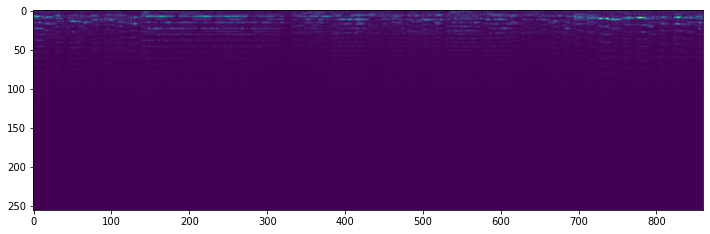

In [ ]:
def show(X, i=0):
  plt.figure(figsize=(12,12))
  plt.imshow(X[i, :, :, 0].astype(np.float32))
  plt.show()

show(X, 1)

We determine image shapes and the our noise dimension.

In [ ]:
z_dim = 100

#  Discriminator
Let's build **discriminator** now. We use an MLP as the discriminator.

In [ ]:
def buildDisc():
  model = Sequential()
  model.add(Conv2D(64, 3, 2, 'same', input_shape=(256, 860, 1)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Conv2D(128, 3, 2, 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Flatten())
  model.add(Dense(1))
  return model

# Generator
Again, we use an MLP for the generator.

In [ ]:
def buildGen(z_dim=100):
  model = Sequential()
  model.add(Dense(64 * 215 * 128, input_shape=(z_dim,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((64, 215, 128)))
  model.add(UpSampling2D())
  model.add(Conv2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(UpSampling2D())
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Conv2D(1, (3, 3), 1, padding='same', activation='tanh'))
  return model

#  GAN
Time to build a model for **GAN**. We build it by cascading the generator and the discriminator.

In [ ]:
def buildGan(disc, gen):
  model = Sequential()
  model.add(gen)
  model.add(disc)
  return model

In [ ]:
disc = buildDisc()
disc.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(True), metrics=['acc'])

gen = buildGen()

disc.trainable = False
gan = buildGan(disc, gen)
gan.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(True))

#  Training

Iteration 50:	D acc: 1.0	D loss: 2.4405985167987193e-31	G loss: 259.7653503417969


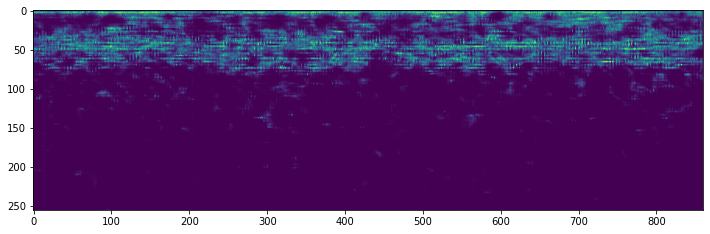

Iteration 100:	D acc: 1.0	D loss: 0.0	G loss: 0.0


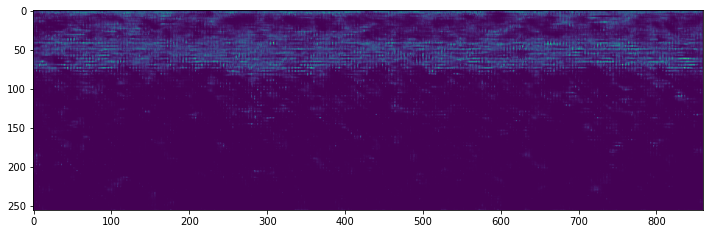

Iteration 150:	D acc: 1.0	D loss: 0.0	G loss: 0.0


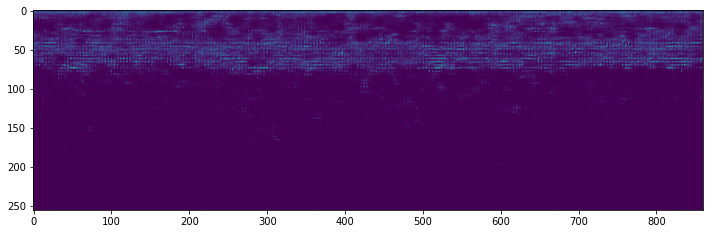

In [ ]:
batch_size = 8
for i in range(20000):
  indexes = np.random.permutation(len(X))[:batch_size]
  Xreal = X[indexes]
  yreal = np.ones((batch_size,))
  noise = np.random.randn(batch_size, z_dim)
  Xfake = gen.predict(noise)
  yfake = np.zeros_like(yreal)
  Xdisc = np.concatenate((Xreal, Xfake))
  ydisc = np.concatenate((yreal, yfake))

  d_loss, d_acc = disc.train_on_batch(Xdisc, ydisc)

  for j in range(5):
    noise = np.random.randn(batch_size, z_dim)
    g_loss = gan.train_on_batch(noise, yreal)

  if not((i+1)%50):
    print(f'Iteration {i+1}:\tD acc: {d_acc}\tD loss: {d_loss}\tG loss: {g_loss}')
    noise = np.random.randn(1, z_dim)
    Xfake = gen.predict(noise)
    show(Xfake)
    saveOutput(Xfake, i)


In [ ]:
gen.save('gen')

INFO:tensorflow:Assets written to: gen/assets


In [ ]:
!mkdir gens
!cp *.wav gens

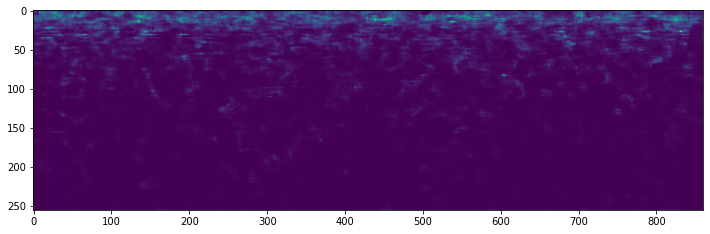

In [ ]:
noise = np.random.randn(1, z_dim)
Xfake = gen.predict(noise)
show(Xfake)
saveOutput(Xfake, 6)

(128, 863)
(1, 257, 863, 1)


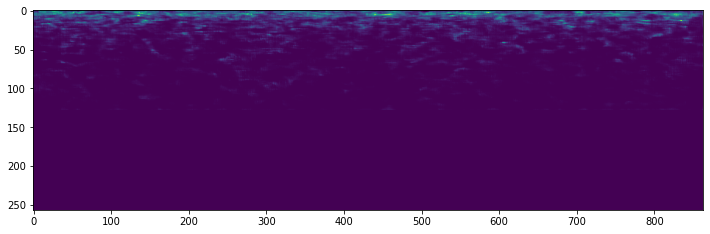

[[-0.99943233 -0.99934399 -0.99949181 -0.99917495 -0.99933702 -0.99864477
  -0.99899578 -0.99940306 -0.99889505 -0.99961203]
 [-0.99705082 -0.9959898  -0.99568492 -0.99435151 -0.99682868 -0.99550831
  -0.99760753 -0.99809527 -0.99748683 -0.99867529]]
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


In [ ]:
XX = postProcess(Xfake[0, :, :, 0], -1)[np.newaxis, :, :, np.newaxis]
print(XX.shape)
saveOutput(XX, 5)
show(XX)
print(XX[0, 120:122, 200:210, 0])
print(XX[0, 220:222, 200:210, 0])

In [ ]:
!zip -r gens.zip gens

  adding: gens/ (stored 0%)
  adding: gens/gen6649.wav (deflated 10%)
  adding: gens/gen1699.wav (deflated 24%)
  adding: gens/gen7649.wav (deflated 19%)
  adding: gens/gen16249.wav (deflated 16%)
  adding: gens/gen15649.wav (deflated 16%)
  adding: gens/gen149.wav (deflated 13%)
  adding: gens/gen349.wav (deflated 18%)
  adding: gens/gen11199.wav (deflated 8%)
  adding: gens/gen12499.wav (deflated 9%)
  adding: gens/gen49.wav (deflated 19%)
  adding: gens/gen7.wav (deflated 26%)
  adding: gens/gen10199.wav (deflated 12%)
  adding: gens/gen8099.wav (deflated 21%)
  adding: gens/gen5799.wav (deflated 7%)
  adding: gens/gen649.wav (deflated 25%)
  adding: gens/gen13399.wav (deflated 16%)
  adding: gens/gen10449.wav (deflated 12%)
  adding: gens/gen3599.wav (deflated 16%)
  adding: gens/gen11849.wav (deflated 7%)
  adding: gens/gen9449.wav (deflated 9%)
  adding: gens/gen18599.wav (deflated 9%)
  adding: gens/gen14499.wav (deflated 18%)
  adding: gens/gen1599.wav (deflated 21%)
  adding: 

#  Testing

In [ ]:
noise = np.random.randn(1, z_dim)
Xfake = gen.predict(noise)
saveOutput(Xfake)
saveOutput(X[0:3], 1)